# National Inventory of Dams

In [1]:
import geopandas as gpd
import pygeohydro as gh

PyGeoHydro offers two function for getting all the publicly available dams in [NID](https://nid.sec.usace.army.mil) database: `get_nid` for retrieving a geo-dataframe of the dams and `get_nid_codes` for pulling definitions of letter codes used in NID.

First, let's get the dams dataframe. Note that running this function might take a while, for example, on a Core i7 with 16 GB of RAM, it takes about 1 min. The main bottleneck is loading all 91K rows into memory.

In [2]:
nid = gh.get_nid()

This dataframe has a property called `attrs` that containes descriptions of NID variables and their units. For example, let's take a look at `VOLUME`'s description:

In [3]:
nid.attrs["VOLUME"]

'(Cubic yards, Number) Total number of cubic yards occupied by the materials used in the dam structure. Portions of powerhouse, locks, and spillways are included only if they are an integral part of the dam and required for structural stability.'

Some of the dam coordinates are either missing or incorrect. Let's filter the data to only include dams that are within Contiguous US.

In [4]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
conus = world[world.name == "United States of America"].geometry.iloc[0][0]
conus = gpd.GeoDataFrame({"FID": [0], "geometry": conus}, crs=world.crs)
nid_conus = nid[nid.within(conus.to_crs(nid.crs).geometry[0])]

Let's check the number dams without correct coordinates.

In [5]:
nid.shape[0] - nid_conus.shape[0]

699

Now, we can use `get_nid_codes` function to get the definition of letter codes that used in NID.

In [6]:
codes = gh.get_nid_codes()

This dataframe is a multi-index dataframe where the first index is code categories and the second one is letter codes.

In [7]:
codes.index.get_level_values(0).unique()

Index(['Modification Type (from Year Modified)', 'Hazard (Potential)',
       'Core Type', 'Dam Type', 'Core Position', 'Owner Type',
       'Core Certainty', 'EAP', 'Foundation Type', 'Foundation Certainty',
       'Spillway Type', 'Purposes'],
      dtype='object', name='Category')

For example, let's get all the dam types.

In [8]:
dam_types = codes.loc["Dam Type"].index
dam_types

Index(['RE', 'ER', 'PG', 'CB', 'VA', 'MV', 'CN', 'MS', 'ST', 'TC', 'OT', 'RC'], dtype='object', name='Code')

Next, we can get a count of each type and plot them.

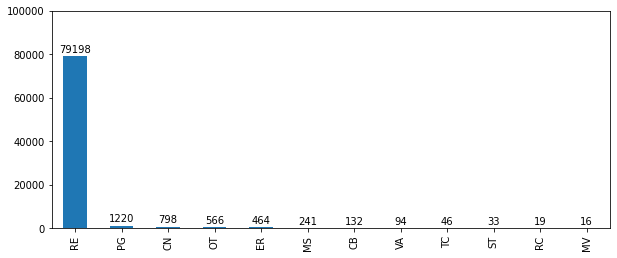

In [9]:
types_count = nid.loc[nid.DAM_TYPE.isin(dam_types), "DAM_TYPE"].value_counts()
ax = types_count[types_count > 0].plot.bar(figsize=(10, 4))
ax.set_ylim(0, 10e4)
for p in ax.patches:
    ax.annotate(
        p.get_height(),
        (p.get_x() + p.get_width() / 2, p.get_height() + 3000),
        ha="center",
        va="center",
    )

Let's compare the spatial distribution of the top five categories, excluding Earth and Other categories.

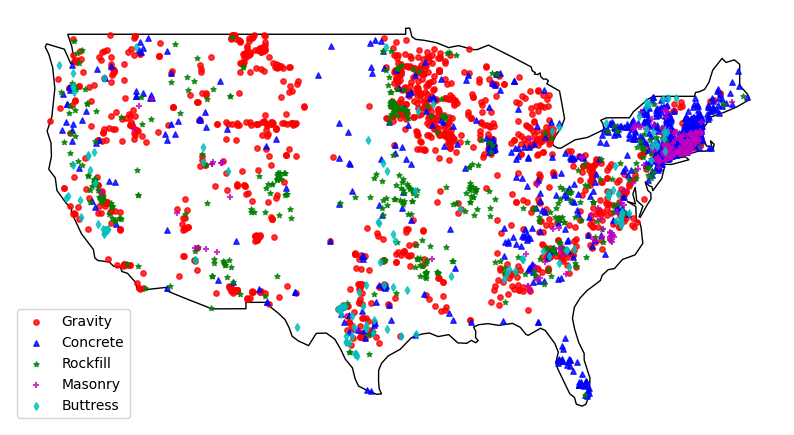

In [10]:
ax = conus.plot(figsize=(10, 6), facecolor="none", edgecolor="k")
top_types = ["PG", "CN", "ER", "MS", "CB"]
marker = dict(zip(top_types, ["o", "^", "*", "+", "d"]))
color = dict(zip(top_types, ["r", "b", "g", "m", "c"]))
for c in top_types:
    nid_conus[nid_conus.DAM_TYPE == c].plot(
        ax=ax,
        alpha=0.8,
        markersize=15,
        marker=marker[c],
        color=color[c],
        label=codes.loc[("Dam Type", c)].item(),
    )
ax.legend(loc="best")
ax.axis(False)
ax.figure.set_dpi(100)
ax.figure.savefig("_static/dams.png", bbox_inches="tight", dpi=100)